In [1]:
import os
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
import pickle
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pickle
import pandas as pd
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data

import plotly.express as px

%matplotlib inline

In [2]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [3]:
path_to_labelled_graphs = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/Oasis_original_new_with_dummy/labelled_graphs/'

In [4]:
correspondence = pickle.load( open( "graph_correspondence_new.pickle", "rb" ))
Oasis_phen = pd.read_excel("/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/OASIS_phenotype.ods", engine="odf")

In [5]:
# Correspondence between sulcal graphs(OASIS) and gender. 
#Oasis_phen[['Subject','M/F']]
oasis_ids = Oasis_phen['Subject'].to_list()
gender = Oasis_phen['M/F'].to_list()

gender_corresp = []

for corr in correspondence:
    corr_id = corr[0].split('_lh')
    
    for o_id, gen in zip(oasis_ids, gender):
        if o_id == corr_id[0]:
            gender_corresp.append([o_id,corr[1],gen])
            
gender_corresp = np.array(gender_corresp)

In [6]:
gender_corresp[:,2]

array(['F', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'M', 'F',
       'F', 'F', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'F',
       'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'F',
       'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F',
       'F', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F',
       'M', 'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'F',
       'M', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F',
       'F', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'F',
       'M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'M',
       'F', 'M', 'M', 'M', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F',
       'M', 'F', 'M', 'F', 'F', 'F', 'M'], dtype='<U19')

In [7]:
unique, counts = np.unique(gender_corresp[:,2], return_counts=True)
dict(zip(unique, counts))

{'F': 69, 'M': 68}

In [8]:
# Create graph level labels (here gender)
onehot = OneHotEncoder(drop='first')
graph_labels = onehot.fit_transform(np.array(gender_corresp)[:,2].reshape(-1,1)).toarray()

In [9]:
# Create pair of graphs 

list_graphs = gp.load_graphs_in_list(path_to_labelled_graphs)

pos_pairs = []
neg_pairs = []

#sulcal_dataset = []

for g1, gen1 in zip(list_graphs, graph_labels):

    for g2, gen2 in zip(list_graphs, graph_labels):
        
        
        graph_remove_dummy_nodes(g1)
        g1.remove_edges_from(nx.selfloop_edges(g1)) 
        
        graph_remove_dummy_nodes(g2)
        g2.remove_edges_from(nx.selfloop_edges(g2))
        
        if g1 != g2:
            
            
            attr_coords_g1 = np.array(list(nx.get_node_attributes(g1,'sphere_3dcoords').values()))
            attr_basin_area_g1 = np.array(list(nx.get_node_attributes(g1,'basin_area').values())).reshape([len(g1),1])
            attr_basin_thickness_g1 = np.array(list(nx.get_node_attributes(g1,'basin_thickness').values())).reshape([len(g1),1])
            attr_depth_g1 = np.array(list(nx.get_node_attributes(g1,'depth').values())).reshape([len(g1),1])
            
            attr_concat_g1 = np.concatenate((attr_coords_g1,attr_basin_area_g1,attr_basin_thickness_g1,attr_depth_g1),axis = 1)
            
            
            
            attr_coords_g2 = np.array(list(nx.get_node_attributes(g2,'sphere_3dcoords').values()))
            attr_basin_area_g2 = np.array(list(nx.get_node_attributes(g2,'basin_area').values())).reshape([len(g2),1])
            attr_basin_thickness_g2 = np.array(list(nx.get_node_attributes(g2,'basin_thickness').values())).reshape([len(g2),1])
            attr_depth_g2 = np.array(list(nx.get_node_attributes(g2,'depth').values())).reshape([len(g2),1])
            
            attr_concat_g2 = np.concatenate((attr_coords_g2,attr_basin_area_g2,attr_basin_thickness_g2,attr_depth_g2),axis = 1)
            
            
            x1 = torch.tensor(attr_concat_g1,dtype=torch.float)
            
            #x1 = torch.tensor(nx.adjacency_matrix(g1).todense(),dtype=torch.float) #adj row
            #y1 = torch.tensor(gen1,dtype=torch.long) # graph label
            edge_index_g1 = torch.tensor(list(g1.edges))
            
            
            x2 = torch.tensor(attr_concat_g2,dtype=torch.float)
            #x2 = torch.tensor(nx.adjacency_matrix(g2).todense(),dtype=torch.float) #adj row
            #y2 = torch.tensor(gen2,dtype=torch.long)
            edge_index_g2 = torch.tensor(list(g2.edges))
            
            
            # y here is pairwise label
            
            if gen1 == gen2:
                
                pos_pairs.append((Data(x=x1, y= torch.tensor([1],dtype=torch.long) , edge_index=edge_index_g1.t().contiguous()),
                                Data(x=x2, y= torch.tensor([1],dtype=torch.long) , edge_index=edge_index_g2.t().contiguous())))  # positive pairs

                
            else:
                
                neg_pairs.append((Data(x=x1, y= torch.tensor([0],dtype=torch.long) , edge_index=edge_index_g1.t().contiguous()),
                                Data(x=x2, y= torch.tensor([0],dtype=torch.long) , edge_index=edge_index_g2.t().contiguous()))) # positive pairs
                

                
                
                #sulcal_dataset.append(from_networkx(g))

In [ ]:
#sulcal_dataset = pos_pairs + neg_pairs

In [10]:
train_dataset = pos_pairs[:5000] + neg_pairs[:5000]
test_dataset = pos_pairs[5000:] + neg_pairs[5000:]

In [11]:
# nx.number_of_nodes(list_graphs[0]),nx.number_of_nodes(list_graphs[1])

# nx.number_of_edges(list_graphs[0]),nx.number_of_edges(list_graphs[1])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [15]:
num_node_features = train_dataset[0][0].num_features
num_node_features

6

In [ ]:
# # Create GNN Model

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
        
#         self.embedding_dim = 32
        
#         self.conv1 = GCNConv(num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, self.embedding_dim)
# #         self.lin = Linear(hidden_channels * 2, 1)
# #         self.sigmoid = nn.Sigmoid()

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         emb = self.conv3(x, edge_index)

#         # 2. Readout layer
#         g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels]

        
#         return g_emb, emb
        

# model = GCN(hidden_channels=32)
# print(model)

In [16]:
# Create GNN Model

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):        
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.in_head = 2
        self.out_head = 1
        
        self.emb_dim = 8
        
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=self.in_head)
        self.conv2 = GATConv(hidden_channels*self.in_head, hidden_channels,concat=False)
        self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
        

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        emb = self.conv3(x, edge_index)

        # 2. Readout layer
        g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels] TopKPooling
        #g_emb = TopKPooling(emb, batch)

        # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
        return g_emb, emb

model = GAT(hidden_channels=32)
print(model)

GAT(
  (conv1): GATConv(6, 32, heads=2)
  (conv2): GATConv(64, 32, heads=1)
  (conv3): GATConv(32, 8, heads=1)
)


In [ ]:
# def criterion(dist, label, margin: float = 1.0):
#     """
#     Computes Contrastive Loss
#     """

#     dist = torch.nn.functional.pairwise_distance(x1, x2)
    
#     dist = torch.sigmoid(dist)
    
#     #dist = dist.argmax(dim=1)

#     loss = (1 - label) * torch.pow(dist, 2) + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
#     loss = torch.mean(loss)

#     return loss

In [17]:
def criterion(x1, x2, label, margin: float = 1.0):
    """
    Computes Contrastive Loss
    """

    dist = torch.nn.functional.pairwise_distance(x1, x2)
    #dist = torch.sigmoid(dist)

    loss = (1 - label) * torch.pow(dist, 2) + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
    loss = torch.mean(loss)

    return loss

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        
        g_emb_g1, node_emb_g1 = model(data[0].x,data[0].edge_index,data[0].batch)
        g_emb_g2, node_emb_g2 = model(data[1].x,data[1].edge_index,data[1].batch)
        
        #loss = criterion(out, data[0].y)
        loss = criterion(g_emb_g1,g_emb_g2, data[0].y) #custom loss
        
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        
        for data in loader:
        
            g_emb_g1, node_emb_g1 = model(data[0].x,data[0].edge_index,data[0].batch)
            g_emb_g2, node_emb_g2 = model(data[1].x,data[1].edge_index,data[1].batch)
            #pred = out.argmax(dim=1)
            #correct += int((pred == data[0].y).sum())

            loss += criterion(g_emb_g1,g_emb_g2, data[0].y)
    return loss
        
    #return correct / len(loader.dataset)  # Derive ratio of correct predictions.
            
            #loss += criterion(g1_emb,g2_emb, data[0].y)

In [19]:
train_curve = []
test_curve = []
for epoch in range(1,100):
    
    train()
    
    train_acc = test(train_loader)
    train_curve.append(train_acc)
    
    test_acc = test(test_loader)
    test_curve.append(test_acc)
        
    print(f'Epoch: {epoch:03d}, Train loss: {train_acc:.4f}, Test loss: {test_acc:.4f}')

Epoch: 001, Train loss: 69.6460, Test loss: 66.2426
Epoch: 002, Train loss: 33.4529, Test loss: 32.5344
Epoch: 003, Train loss: 22.7827, Test loss: 21.4238
Epoch: 004, Train loss: 21.4615, Test loss: 19.3809
Epoch: 005, Train loss: 22.3423, Test loss: 20.3100
Epoch: 006, Train loss: 21.5044, Test loss: 18.6872
Epoch: 007, Train loss: 21.3429, Test loss: 18.6079
Epoch: 008, Train loss: 21.7405, Test loss: 19.1434
Epoch: 009, Train loss: 22.6223, Test loss: 20.2803
Epoch: 010, Train loss: 21.7027, Test loss: 18.9863
Epoch: 011, Train loss: 22.0482, Test loss: 19.5764
Epoch: 012, Train loss: 28.7294, Test loss: 26.7400
Epoch: 013, Train loss: 21.5524, Test loss: 18.5405
Epoch: 014, Train loss: 21.5466, Test loss: 18.6892
Epoch: 015, Train loss: 21.4157, Test loss: 18.5268
Epoch: 016, Train loss: 31.3396, Test loss: 28.7304
Epoch: 017, Train loss: 22.2602, Test loss: 19.6750
Epoch: 018, Train loss: 21.8753, Test loss: 18.4287
Epoch: 019, Train loss: 42.6517, Test loss: 40.3610
Epoch: 020, 

# Loss curve

In [20]:
x_axis = np.arange(0,99,1)

Text(0, 0.5, 'Train / Test Loss')

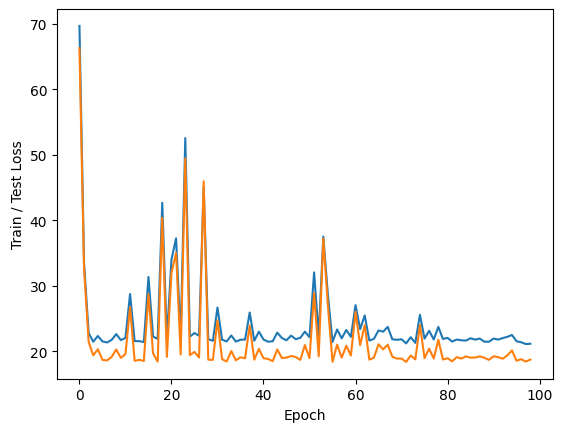

In [21]:
plt.plot(x_axis,train_curve)
plt.plot(x_axis,test_curve)
plt.xlabel('Epoch')
plt.ylabel('Train / Test Loss')

# Graph embeddings

In [25]:
list_graphs = gp.load_graphs_in_list(path_to_labelled_graphs)

sulcal_dataset = []

for i,g in enumerate(list_graphs):
    graph_remove_dummy_nodes(g) # remove dummy nodes
    g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    
    attr_coords_g = np.array(list(nx.get_node_attributes(g,'sphere_3dcoords').values()))
    attr_basin_area_g = np.array(list(nx.get_node_attributes(g,'basin_area').values())).reshape([len(g),1])
    attr_basin_thickness_g = np.array(list(nx.get_node_attributes(g,'basin_thickness').values())).reshape([len(g),1])
    attr_depth_g = np.array(list(nx.get_node_attributes(g,'depth').values())).reshape([len(g),1])
        
    attr_concat_g = np.concatenate((attr_coords_g,attr_basin_area_g,attr_basin_thickness_g,attr_depth_g),axis = 1)
    
    x = torch.tensor(attr_concat_g,dtype=torch.float)
    #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    y = torch.tensor(graph_labels[i],dtype=torch.long)
    edge_index = torch.tensor(list(g.edges))
    
    sulcal_dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))
    

In [26]:
real_emb = []
  
all_graph = DataLoader(sulcal_dataset, batch_size=len(sulcal_dataset), shuffle=False)

for data in all_graph:
    graph_emb,node_emb = model(data.x, data.edge_index, data.batch)
    
node_emb = node_emb.detach().numpy()
graph_emb = graph_emb.detach().numpy()


In [27]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)


tsne_graph = tsne.fit_transform(graph_emb)
tsne_graph.shape

(137, 2)

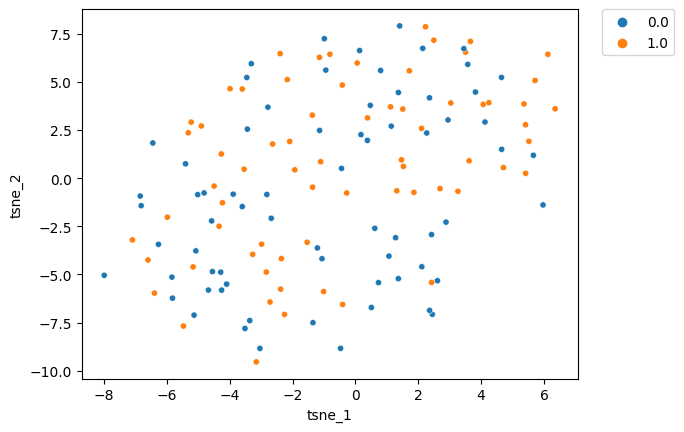

In [28]:
#subj_labels_lst = np.arange(0,137,1)
graph_labels_lst = [lab[0] for lab in graph_labels]
tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':graph_labels_lst})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=20)
lim = (tsne_graph_df.min()-5, tsne_graph_df.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# Node embeddings

In [ ]:
# gender label for each graph

pit_labels = []
for i,g in enumerate(list_graphs):
    size_g = nx.number_of_nodes(g)
    pit_labels.extend(list(graph_labels[i]) * size_g)

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(node_emb)
tsne_result.shape

In [ ]:
sns.set(rc={'figure.figsize':(15,11)})
#sns.set(rc={'axes.facecolor':'#DCE8F4'})

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': pit_labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=30)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


In [ ]:
n_components = 3
tsne2 = TSNE(n_components)

tsne_graph = tsne2.fit_transform(graph_emb)
tsne_graph.shape


tsne_graph_3d = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'tsne_3': tsne_graph[:,2], 'label':graph_labels_lst})


fig = px.scatter_3d(tsne_graph_3d, x = 'tsne_1',y = 'tsne_2',z = 'tsne_3',color='label')
fig.update_traces(marker={'size': 4})


fig.show()

## Classification on graph embeddings

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [30]:
clf = LogisticRegression(random_state=0)
clf.fit(graph_emb[:70], graph_labels_lst[:70])

LogisticRegression(random_state=0)

In [31]:
clf.score(graph_emb[:70], graph_labels_lst[:70])

0.6142857142857143

In [32]:
clf.score(graph_emb[70:], graph_labels_lst[70:]) #test set

0.40298507462686567

In [33]:
clf_svm = SVC(gamma='auto',kernel='rbf')

In [34]:
clf_svm.fit(graph_emb[:70], graph_labels_lst[:70])

SVC(gamma='auto')

In [35]:
clf_svm.score(graph_emb[70:],graph_labels_lst[70:]) #test set

0.3880597014925373